# Imports

In [1]:
# The usual modular suspects
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math

# Of Mice & Machine Learning Mavericks
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Personal Effects 
from acquire import get_telco_data
# from prepare import prep_telco
# from explore import percentage_stacked_plot, compute_mutual_information, create_models, boxplot, countplot, confusion_matrix_plot
import env
from FUNctions import describe_data, display_uniques

# Data Acquisition

In [2]:
df = get_telco_data()
describe_data(df)

Using cached csv
The first three rows are: 
----------------------------------------------------------
   payment_type_id  internet_service_type_id  contract_type_id customer_id  \
0                2                         1                 2  0002-ORFBO   
1                2                         1                 1  0003-MKNFE   
2                1                         2                 1  0004-TLHLJ   

   gender  senior_citizen partner dependents  tenure phone_service  ...  \
0  Female               0     Yes        Yes       9           Yes  ...   
1    Male               0      No         No       9           Yes  ...   
2    Male               0      No         No       4           Yes  ...   

  tech_support streaming_tv streaming_movies paperless_billing  \
0          Yes          Yes               No               Yes   
1           No           No              Yes                No   
2           No           No               No               Yes   

  monthly_charges 

# Data Preparation

In [ ]:
# may need to restore a few columns from my former prep
# for example, although every DSL case has both phone and internet, there may still be overlap
# with fiber, so I need to be careful to distinguish this case. 

#df.head()

# I will start by observing columns that were not used during the tableau project. 

In [3]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable for independent variable of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization

    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df[column], df['churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

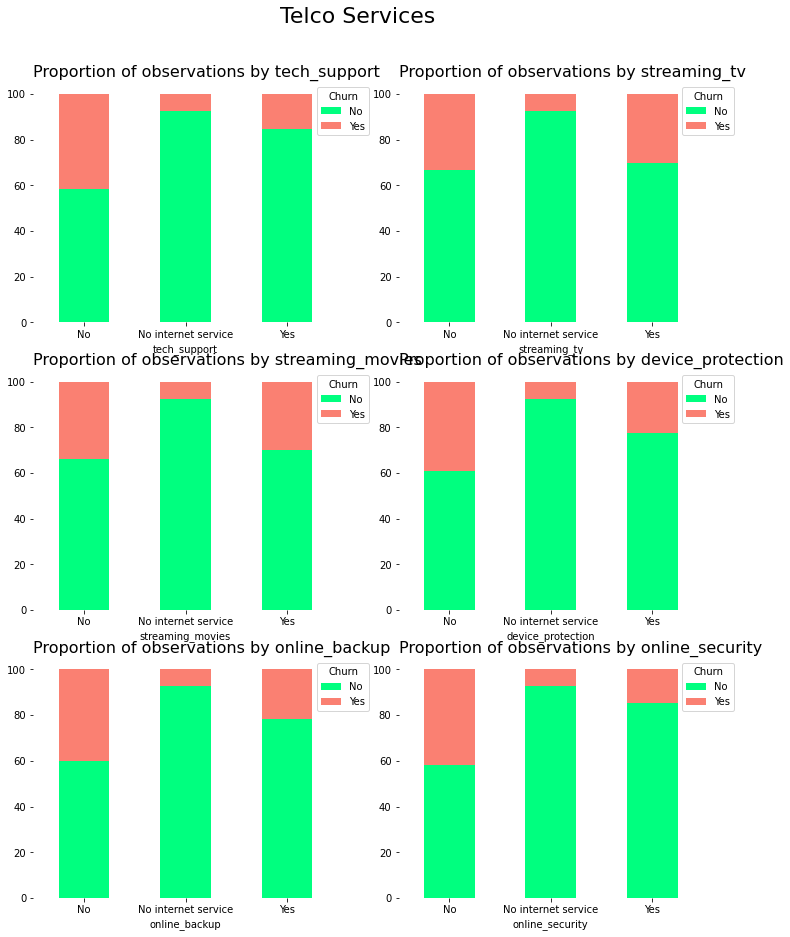

In [8]:
services = ['tech_support', 'streaming_tv', 'streaming_movies', 'device_protection', 'online_backup', 'online_security']
percentage_stacked_plot(services, "Telco Services")

In [ ]:
# I may get some interesting results from each of the fields other than what a person streams. 
# I'll drop streaming movies and tv. Online Security and Tech Support are especially catching my eye
# This makes me wonder whether or not the CX element of those is faulty. Device protection and online
# backup are about the same, and although not as significant as the former group, I will keep them for now. 


In [3]:
# bringing in my old prep data and making modifications meow. 

def prep_telco(df):
    # drop unnecessary, unhelpful, or duplicate columns. 
    df = df.drop(columns=['customer_id', 'payment_type_id', 'internet_service_type_id',
                                'contract_type_id', 'total_charges', 'streaming_tv',
                                'streaming_movies'])
    
    # Encode the categorical variables. 
  #  df['is_male'] = np.where(df.gender == 'Male', 1, 0)
    df['has_partner'] = np.where(df.partner == 'Yes', 1, 0)
    df['has_dependent'] = np.where(df.dependents == 'Yes', 1, 0)
 #   df['has_phone'] = np.where(df.phone_service == 'Yes', 1, 0)
 #   df['multiple_lines'] = np.where(df.multiple_lines == 'Yes', 1, 0)
 #   df['has_internet'] = np.where(df.internet_service_type == "None", 0, 1)
    df['fiber'] = np.where(df.internet_service_type == "Fiber optic", 1, 0)
    df['dsl'] = np.where(df.internet_service_type == "DSL", 1, 0)
    df['no_contract'] = np.where(df.contract_type == "Month-to-month", 1, 0)
    df['electronic_check'] = np.where(df.payment_type == "Electronic check", 1, 0)
 #   df['paperless_bills'] = np.where(df.paperless_billing == 'Yes', 1, 0)
    df['autopay'] = np.where(df.payment_type.str.contains('automatic') == True, 1, 0)
    df['churn'] = np.where(df.churn == 'Yes', 1, 0)
    df['technical_support'] = np.where(df.tech_support == 'Yes', 1, 0)
    df['device_protection_plan'] = np.where(df.device_protection == 'Yes', 1, 0)
    df['onlinebackup'] = np.where(df.tech_support == 'Yes', 1, 0)
    df['onlinesecurity'] = np.where(df.tech_support == 'Yes', 1, 0)
    
    # through this process, using a dummies function has become essentially irrelevant. 
    
    # drop redundant, categorical variables. 
    df = df.drop(columns=['gender', 'partner', 'dependents', 'phone_service',
                          'internet_service_type', 'contract_type', 'payment_type',
                          'paperless_billing', 'tech_support', 'device_protection',
                          'online_backup', 'online_security', 'multiple_lines'])
    return df 

In [ ]:
## instead of manually doing this, I may need to use one-hot encoding instead. I will check later. I need to read
## more about this process, because right now I am just messily going all over the place. 
#
## one-hot encoding (categorical variables with more than two levels)
#one_hot_encoding_columns = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
#                            'TechSupport', 'StreamingTV',  'StreamingMovies', 'Contract', 'PaymentMethod']
#
## encode categorical variables with more than two levels using one-hot encoding
#df_telco_transformed = pd.get_dummies(df_telco_transformed, columns = one_hot_encoding_columns)

In [4]:
df = prep_telco(df)

In [6]:
describe_data(df)

The first three rows are: 
----------------------------------------------------------
   senior_citizen  tenure  monthly_charges  churn  has_partner  has_dependent  \
0               0       9             65.6      0            1              1   
1               0       9             59.9      0            0              0   
2               0       4             73.9      1            0              0   

   has_internet  fiber  dsl  no_contract  electronic_check  autopay  \
0             1      0    1            0                 0        0   
1             1      0    1            1                 0        0   
2             1      1    0            1                 1        0   

   technical_support  device_protection_plan  onlinebackup  onlinesecurity  
0                  1                       0             1               1  
1                  0                       0             0               0  
2                  0                       1             0               

In [ ]:
# No nulls to worry about, and everything is looking clean and accurate. 
# I do have 19 columns though, and many of them will probably not aid my quest. 
# I'll look at more. 

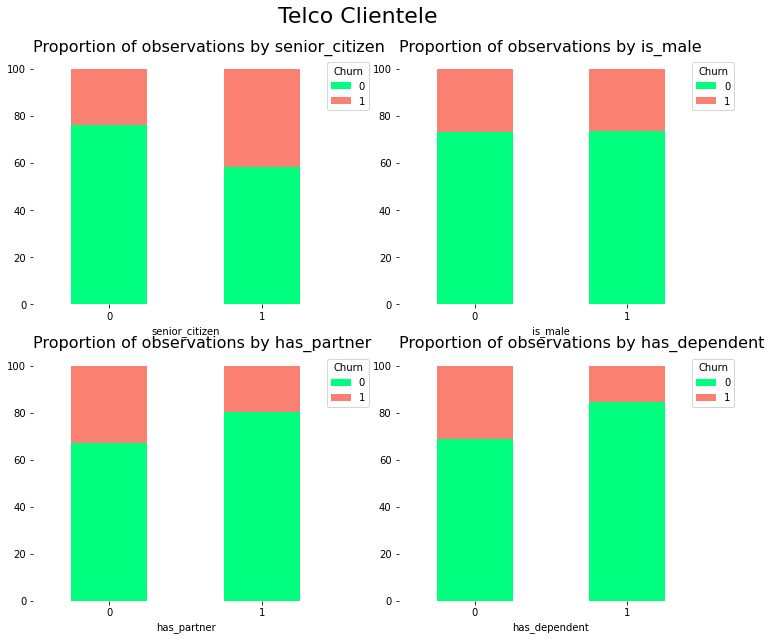

In [14]:
clientele = ['senior_citizen', 'is_male', 'has_partner', 'has_dependent']
percentage_stacked_plot(clientele, 'Telco Clientele')

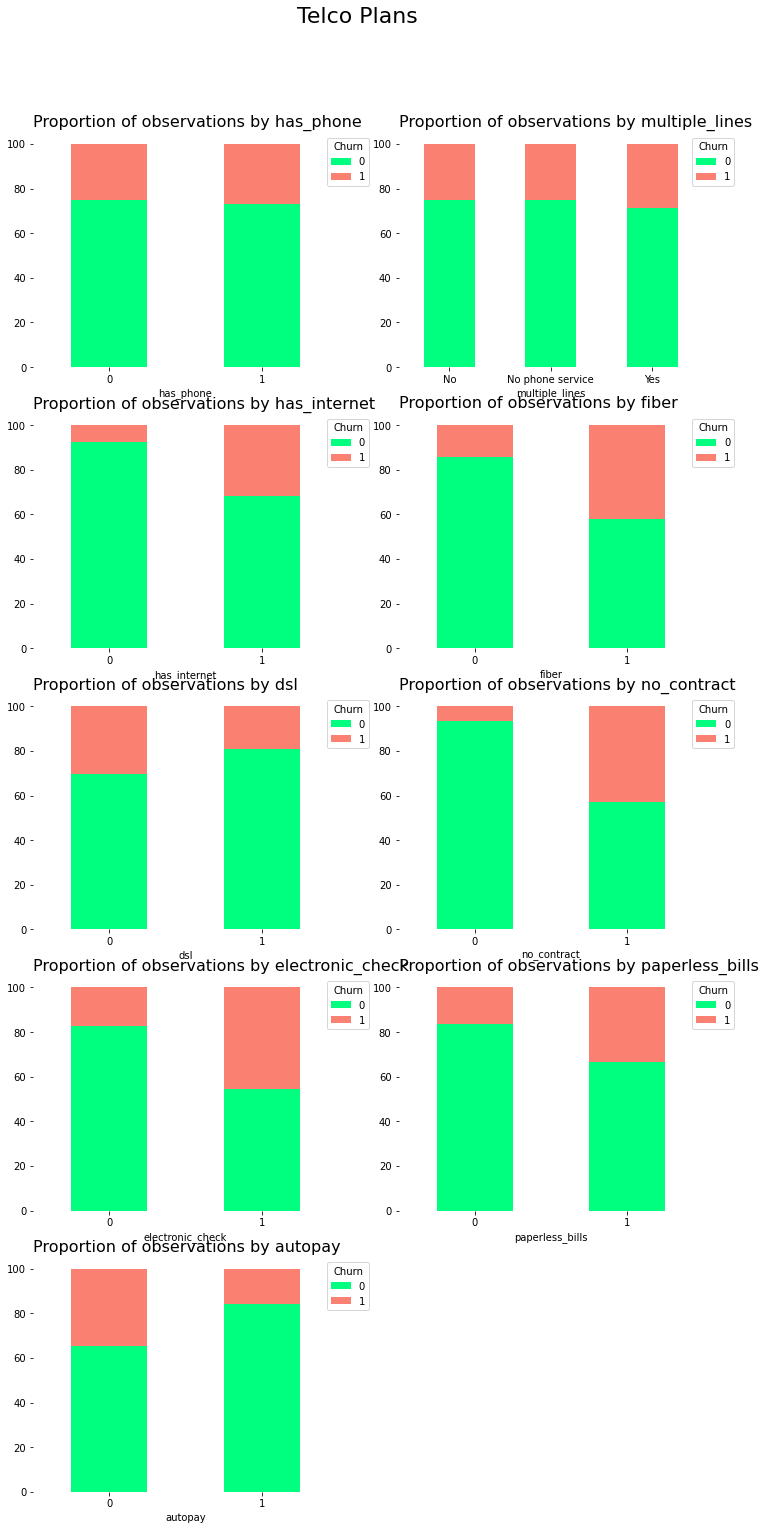

In [16]:
# This shows there is no reason to keep gender under consideration. 
# will drop in the final prep function. 

considerations = ['has_phone', 'multiple_lines', 'has_internet', 'fiber', 'dsl', 'no_contract', 'electronic_check', 'paperless_bills', 'autopay']
percentage_stacked_plot(considerations, 'Telco Plans')

In [ ]:
# has_phone and multiple_lines definitely should go. Surprisingly, by proportion, fiber is of more
# concern and consequence than DSL. But due to the sheer mass of the userbase, I will keep it under consideration.
# by the end I may choose to include the one and two year plan, as they will help for drawing comparison
# among DSL. We shall see. I am hashing out the ones I won't need up above. 
# in fact, fiber plays almost just as much of a tremendous role and influence as no_contract (monthly payments) does.
# paperless_bills is also unnecessary, as it has become clear that mailed checks play a small role, and likely
# find their main use through the elderly. We know through autopay that mailed checks are not included, 
# and that electronic checks are the chief offender, so we can do away with this column. 

# Can't help but wonder if there are cases where those without internet are being charged service charges,
# i.e. the elderly; but that won't factor into this analyses. 

In [29]:
# dropped a few more via prep hashing, let's see
df.head()

,senior_citizen,tenure,monthly_charges,churn,has_partner,has_dependent,has_internet,fiber,dsl,no_contract,electronic_check,autopay,technical_support,device_protection_plan,onlinebackup,onlinesecurity
0,0,9,65.6,0,1,1,1,0,1,0,0,0,1,0,1,1
1,0,9,59.9,0,0,0,1,0,1,1,0,0,0,0,0,0
2,0,4,73.9,1,0,0,1,1,0,1,1,0,0,1,0,0
3,1,13,98.0,1,1,0,1,1,0,1,1,0,0,1,0,0
4,1,3,83.9,1,1,0,1,1,0,1,0,0,1,0,1,1


### Splitting

In [5]:
def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=777, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.3, 
                                   random_state=777, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [6]:
train, validate, test = split_telco_data(df)

In [7]:
train.shape, validate.shape, test.shape
# columns line up, sweet. 

((3943, 16), (1691, 16), (1409, 16))

In [8]:
X_train, y_train = train.drop(columns='churn'), train[['churn']]
X_validate, y_validate = validate.drop(columns='churn'), validate[['churn']]
X_test, y_test = test.drop(columns='churn'), test[['churn']]

In [31]:
# Establish our baseline.  The rate at which the assumption of the majority class matches the real values.
# If a model does not perform better than this, it would not be wise to deploy.
baseline = (y_train.value_counts().idxmax() == y_train).mean()
train['baseline'] = 0
baseline

churn    0.73472
dtype: float64

In [10]:
type(X_train)
X_train.head()
#y_train.head()

,senior_citizen,tenure,monthly_charges,has_partner,has_dependent,has_internet,fiber,dsl,no_contract,electronic_check,autopay,technical_support,device_protection_plan,onlinebackup,onlinesecurity
6822,0,55,90.15,1,0,1,0,1,0,1,0,1,1,1,1
942,0,67,109.70,1,0,1,1,0,0,0,1,1,1,1,1
5669,0,8,75.00,1,0,1,1,0,1,1,0,0,0,0,0
3357,0,1,20.20,0,0,0,0,0,1,0,0,0,0,0,0
5964,0,66,62.50,0,0,1,0,1,0,0,1,1,1,1,1


# Data Exploration and Pre-Processing

AxesSubplot(0.125,0.125;0.775x0.755)


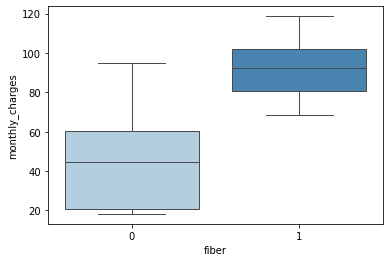

In [90]:
print(f"{sns.boxplot(x='fiber', y='monthly_charges', data=train, palette='Blues', linewidth=1)}")

AxesSubplot(0.125,0.125;0.775x0.755)


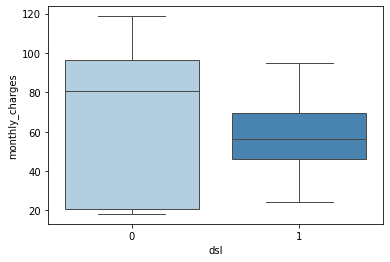

In [83]:
print(f"{sns.boxplot(x='dsl', y='monthly_charges', data=train, palette='Blues', linewidth=1)}")

In [119]:
# May scale the floats. 

In [22]:
plots = {1 : [111], 2: [121, 122], 3: [131, 132, 133], 4: [221, 222, 223, 224],
         5: [231, 232, 233, 234, 235], 6: [231, 232, 233, 234, 235, 236]}

# Create a function to generate countplots:
def countplot(x, y, df):
    
    rows = int(str(plots[len(y)][0])[0])
    columns = int(str(plots[len(y)][0])[1])
    
    plt.figure(figsize=(6*columns, 6*rows))
    
    for i, j in enumerate(y):
        plt.subplot(plots[len(y)][i])
        ax = sns.countplot(x=j, hue=x, data=df, palette="Blues", alpha=1, linewidth=0.8, edgecolor="black")
        ax.set_title(j)
        
    return plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

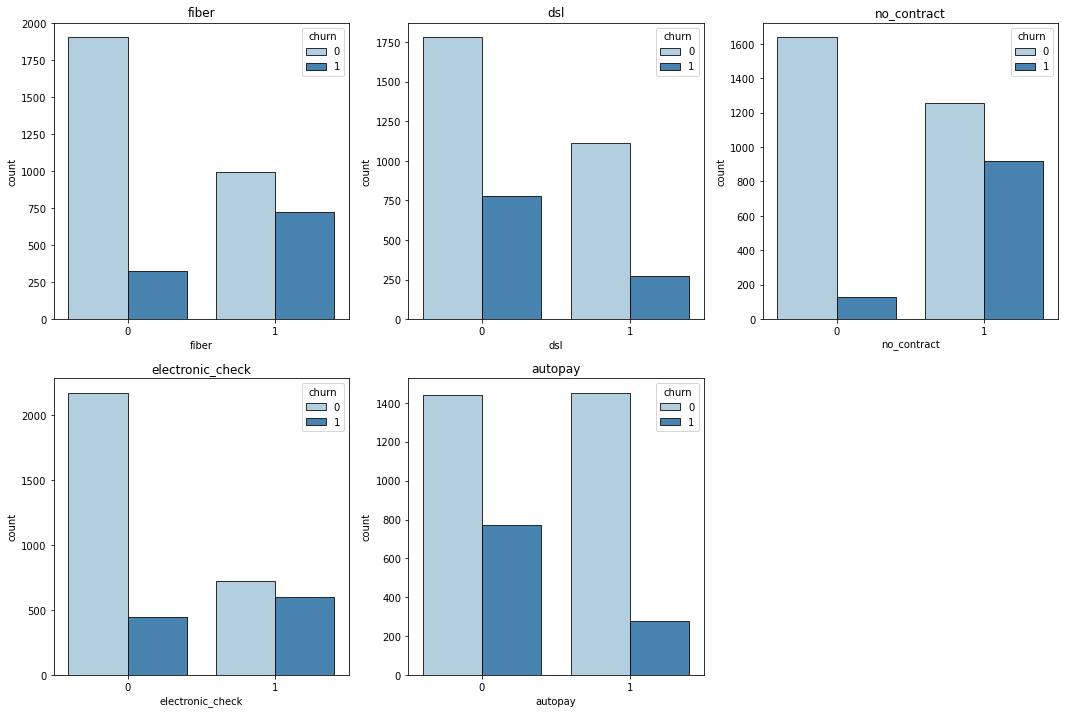

In [34]:
pay_traits = ['fiber', 'dsl', 'no_contract', 'electronic_check', 'autopay']
countplot("churn", ['fiber', 'dsl', 'no_contract', 'electronic_check', 'autopay'], train)

<function matplotlib.pyplot.show(close=None, block=None)>

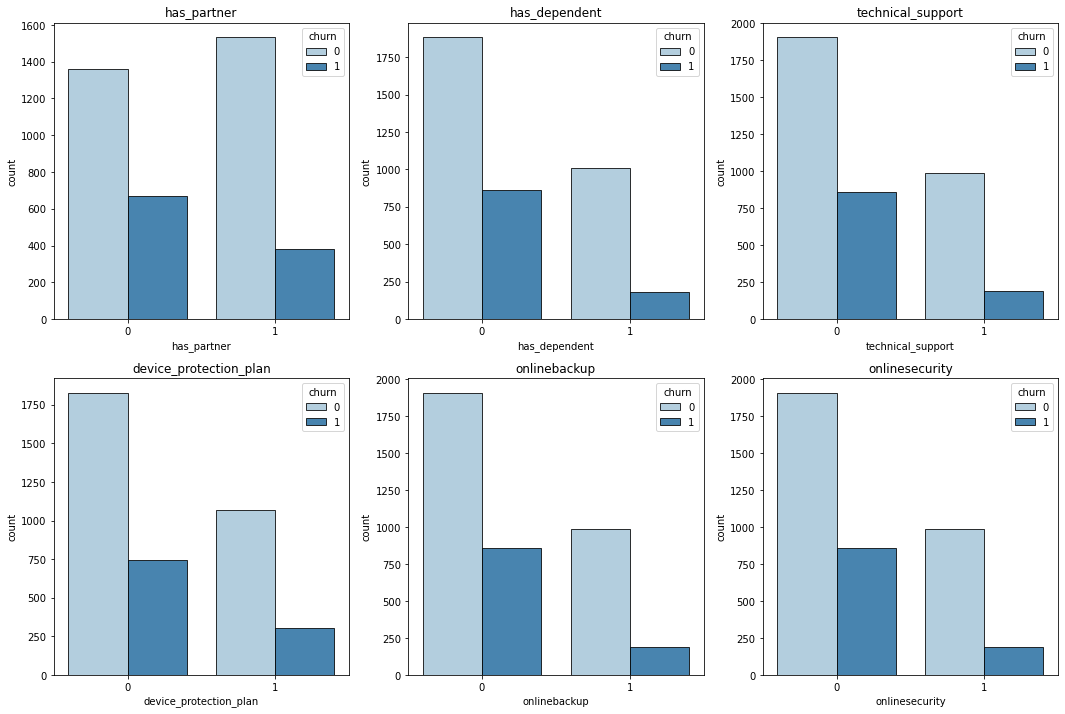

In [35]:
cust_traits = ['has_partner', 'has_dependent', 'technical_support', 'device_protection_plan', 'onlinebackup', 'onlinesecurity']
countplot("churn", ['has_partner', 'has_dependent', 'technical_support', 'device_protection_plan', 'onlinebackup', 'onlinesecurity'], train)


In [26]:
# all of the online services actually line up suspiciously well. I'm supposing it's a necessary inclusion for one 
# of the internet services like Fiber. 

In [32]:
accuracy_score(train.churn, train.baseline)

0.7347197565305605

In [44]:
def create_models(seed=777):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    
    return models

models = create_models()

In [42]:
def confusion_matrix_plot(X_train, y_train, classifier, y_pred, classifier_name):
    fig, ax = plt.subplots(figsize=(7, 6))
    plot_confusion_matrix(classifier, X_test, y_test, display_labels=["No Churn", "Churn"], cmap=plt.cm.Blues, normalize=None, ax=ax)
    ax.set_title(f'{classifier_name} - Confusion Matrix')
    plt.show()
    
    print(f" Train's Accuracy Score: {classifier.score(X_train, y_train)}")
    
# classifier will be along the lines of KNN, or RF, or LR

In [ ]:
# To analyse categorical feature distribution
categorical_features = [ ‘gender’, ‘SeniorCitizen’, ‘Partner’,
 ‘Dependents’, ‘PhoneService’, ‘MultipleLines’, ‘InternetService’,
 ‘OnlineSecurity’, ‘OnlineBackup’, ‘DeviceProtection’, ‘TechSupport’, ‘StreamingTV’, ‘StreamingMovies’, ‘PaymentMethod’,
 ‘PaperlessBilling’, ‘Contract’ ]
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 20) )
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
 if col == COLS — 1: row += 1
 col = i % COLS
 df[df.Churn==’No’][categorical_feature].value_counts().plot(‘bar’, width=.5, ax=ax[row, col], color=’blue’, alpha=0.5).set_title(categorical_feature)
 df[df.Churn==’Yes’][categorical_feature].value_counts().plot(‘bar’, width=.3, ax=ax[row, col], color=’orange’, alpha=0.7).set_title(categorical_feature)
 plt.legend([‘No Churn’, ‘Churn’])
 fig.subplots_adjust(hspace=0.7)